What I've done so far

In [1]:
from cycler import cycler
import geopandas as gpd
from glob import glob
import dask.dataframe as da
from dask.distributed import LocalCluster, Client
import matplotlib.pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import json
# from dem_utils import ArcticDEM
from tqdm import tqdm
import numpy as np
import pandas as pd
import numpy as np
from shapely import wkt
import utils
import cartopy.crs as ccrs
import shapely
from rasterio.features import rasterize
from rasterio.enums import Resampling
import seaborn as sns
# import odc.geo.xr
from cycler import cycler
prj = ccrs.Stereographic(
    central_latitude=90,
    central_longitude=-45,
    true_scale_latitude=70
)
import itertools

In [2]:
# helper functions
def hexbin(x, y, color, **kwargs):
    # facetgrid hexbin func
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=30, cmap=cmap, **kwargs)
    

def add_geom_mask(ds, geom, buffer=200):
    # buffer geometry, with square ends
    buff_geom = geom.buffer(buffer, cap_style=3)
    
    # empty array of same x, y dim shape as merged
    arr = np.zeros((ds.sizes['y'], ds.sizes['x']))
    
    # rasterize
    burned = rasterize(shapes=[(buff_geom, 1)],
                       fill=0,
                       out=arr,
                       transform=ds.rio.transform())
    
    # merged rasterized with all other dataarrays
    merged = xr.merge([ds, xr.DataArray(data=burned,
                                        dims=['y','x'],
                                        coords={'y': ds.y,
                                                'x': ds.x}).rename('buffer_aoi')])

    return merged


def get_line(d):
    '''
    grab centreline from directory
    '''
    with open(f'{d}/download_notes.txt', 'r') as notes:
        notes = json.load(notes)
        return wkt.loads(notes['centreline'])

def get_ds(d):
    '''
    grab dem trend from directory
    '''
    _f = glob(f'{d}/coregistered/robust_spatial*.zarr')
    assert len(_f) == 1, 'not enough / too many .zarr dems'
    return xr.open_dataarray(_f[0], engine='zarr')

def sample_along_line(ds, line, freq=250):
    '''
    sample dhdt xarray along centreline
    '''
    
    points = [
        line.interpolate(x) for
        x in np.arange(0, line.length+freq, freq)
        ]
    distance = [line.project(p)/1000 for p in points]
    x = [p.x for p in points] 
    y = [p.y for p in points]
    df = pd.DataFrame({'distance (km)': distance,
                       'x': x,
                       'y': y})
    idx = df.set_index('distance (km)').to_xarray()
    return ds.interp(x=idx['x'],
                     y=idx['y'])
    

def plot_profile(d, ax):
    '''
    plot dhdt profile
    '''
    profile = sample_along_line(d)
    profile.sel(result='slope').plot(c='k',
                                     ax=ax)
    high = profile.sel(result='slope').max()
    low = profile.sel(result='slope').min()
    span = high - low
    ax.fill_between(profile['distance (km)'],
                    y1 = profile.sel(result='low_slope'),
                    y2 = profile.sel(result='high_slope'),
                    color='lightgrey',
                    alpha=0.8,
                    label="95% CI")
    ax.set_ylim(low - (high-low),
                high + (high-low))
    ax.set_ylabel('dh/dt (m/yr)')
    ax.legend(loc='upper left')
    ax.axhline(0, c='k', lw=0.5, zorder=0)
    ax.set_title(None)
    
def plot_xeqy(ax, c='gray'):
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ax.plot([max(minx, miny), (min(maxx, maxy))],
            [max(minx, miny), (min(maxx, maxy))], c=c, zorder=0)
    

def samples_groupby(samples, by=['where', 'region', 'lake_land', 'mid_bin']):
    '''
    group elevation samples by region/where/lake_land
    useful for plotting scatter of lake SEC vs. land SEC for different groupings
    e.g. symbolised by greenland/iceland (where) or by greenlandic region
    '''    
    lower = lambda x: np.quantile(x, 0.25)
    upper = lambda x: np.quantile(x, 0.75)

    ## add / remove region if needed
    slope_by_z = samples.groupby(by,
                                observed=True)['slope'].agg([lower,
                                                            upper,
                                                            'median']).reset_index()
    by.remove('lake_land')
    lake_land_df = pd.merge(
        slope_by_z.loc[slope_by_z['lake_land']=='land'].rename(columns={'<lambda_0>':'land_lower',
                                                                        '<lambda_1>':'land_upper',
                                                                        'median': 'land_median'}),
        slope_by_z.loc[slope_by_z['lake_land']=='lake'].rename(columns={'<lambda_0>':'lake_lower',
                                                                        '<lambda_1>':'lake_upper',
                                                                        'median': 'lake_median'}),
        left_on=by,
        right_on=by
        )

    ## nonsense for errorbars
    lake_land_df['land_low_err'] = lake_land_df['land_median'] - lake_land_df['land_lower']
    lake_land_df['land_up_err'] = lake_land_df['land_upper'] - lake_land_df['land_median']

    lake_land_df['lake_low_err'] = lake_land_df['lake_median'] - lake_land_df['lake_lower']
    lake_land_df['lake_up_err'] = lake_land_df['lake_upper'] - lake_land_df['lake_median']
    
    return lake_land_df


In [3]:
# basic inputs metadata
site_directories = glob('../data/id*')
site_directories.remove('../data/id32_1327449x_-2520905y')  # removing dodgy 32


centrelines = gpd.read_file('../data/streams_v3.geojson') # removing dodgy 32
centrelines = centrelines.loc[centrelines.index != 32]

basins = (gpd.read_file('../data/basins/Greenland_Basins_PS_v1.4.2.shp')
          .dissolve('SUBREGION1'))
centrelines = centrelines.sjoin(basins.drop(columns=['NAME', 'GL_TYPE']),
                                how='left'
                                ).rename(columns={'index_right': 'region'})


## Surface elevation change

** NOTE TO SELF: MANUALLY REMOVE `id32` AS THOSE RESULTS ARE CLEARLY JUNK **

### meta data

In [4]:
# grab some meta data
dem_ids = []
dem_counts = []
useful_dem_counts = []
years = []
for d in site_directories:
    df= pd.read_parquet(
        os.path.join(d, 'coregistration_metadata.parquet')
        )
    dem_ids += df['to_reg_dem_id'].unique().tolist()
    dem_counts.append(len(df['to_reg_dem_id'].unique()))
    useful_dem_counts.append(((df['nmad_after'] < 2) & (df['median_after'].abs() < 1)).sum())
    years.append((df.index.min().year, df.index.max().year))

In [5]:
# show the meta data
print('number of study sites, by location and type')
print(centrelines.groupby(['where', 'lake_land'])['geometry'].count().to_markdown())

print(centrelines.groupby(['where', 'region', 'lake_land'])['geometry'].count().to_markdown())

print(f'\ntotal of {len(dem_ids)} _sections_ of DEMs used and coregistered (total of: {len(set(dem_ids))} tiles)')
print(f'each of the 36 study sites on average used {np.mean(dem_counts):.0f}'
      f'(mean) {np.median(dem_counts):.0f} (median) DEMs.',
      '\n(where used means coregistered)\n')

print('Coregistered DEMs were removed from subsequent analyses if they '
      'failed to meet NMAD and MDOST of 2 m and ±1 m, respectively')
print(f'the site with the fewest/most DEMs used {np.min(useful_dem_counts):.0f}/{np.max(useful_dem_counts):.0f}. '
      f'mean/median: {np.mean(useful_dem_counts):.0f}/{np.median(useful_dem_counts):.0f}')

number of study sites, by location and type
|                       |   geometry |
|:----------------------|-----------:|
| ('greenland', 'lake') |         14 |
| ('greenland', 'land') |          9 |
| ('iceland', 'lake')   |          7 |
| ('iceland', 'land')   |          5 |
|                             |   geometry |
|:----------------------------|-----------:|
| ('greenland', 'NE', 'lake') |          4 |
| ('greenland', 'NO', 'lake') |          1 |
| ('greenland', 'NO', 'land') |          1 |
| ('greenland', 'NW', 'lake') |          2 |
| ('greenland', 'NW', 'land') |          1 |
| ('greenland', 'SW', 'lake') |          7 |
| ('greenland', 'SW', 'land') |          7 |

total of 2119 _sections_ of DEMs used and coregistered (total of: 1595 tiles)
each of the 36 study sites on average used 61(mean) 49 (median) DEMs. 
(where used means coregistered)

Coregistered DEMs were removed from subsequent analyses if they failed to meet NMAD and MDOST of 2 m and ±1 m, respectively
the site w

In [6]:
# read the coregistration metadata
dfs = []
for d in site_directories:
    df = pd.read_parquet(
        os.path.join(d, 'coregistration_metadata.parquet')
        )
    
    ls_path = glob('line_*.geojson', root_dir=d)
    assert len(ls_path)==1, 'oops'
    ls = gpd.read_file(
        os.path.join(d, ls_path[0])
    )
    
    df['where'] = ls.loc[0, 'where']
    df['lake_land'] = ls.loc[0, 'lake_land']
    df['id'] = int(d.split('_')[0].split('id')[-1])
    dfs.append(df)
    
coreg_meta = pd.concat(dfs)

In [ ]:
## plot to coregistration metadata
fig, axs = plt.subplots(ncols=2, figsize=[8,4])

# MEDIAN
sns.scatterplot(data=coreg_meta,
                x='median_after',
                y='median_before',
                hue='lake_land',
                style='where',
                s=10,
                markers=['o','s'],
                ax=axs[0],
                legend=False)

axs[0].set(xlim=(-5, 5),
       ylim=(-22, 25)
)
axs[0].axhline(0, c='gray', zorder=0, lw=0.5)
axs[0].axvline(0, c='gray', zorder=0, lw=0.5)
plot_xeqy(axs[0])

axs[0].fill_between([-5, -1], -22, 25, color='lightgray', alpha=0.5)
axs[0].fill_between([1, 5], -22, 25, color='lightgray', alpha=0.5)

axs[0].set_title('Medians')

## NMAD
sns.scatterplot(data=coreg_meta,
                x='nmad_after',
                y='nmad_before',
                hue='lake_land',
                style='where',
                s=10,
                markers=['o','s'],
                ax=axs[1],
                legend=False)

axs[1].set(xlim=(0, 5),
           ylim=(0, 7.5)
)
plot_xeqy(axs[1])
axs[1].fill_between([2, 7.5], 0, 7.5, color='lightgray', alpha=0.5)
axs[1].set_title('NMAD')

plt.subplots_adjust(wspace=0.25)

### results

Buffered each centreline by 200 m and extracted rates of SEC for all gridsquares in buffered region along with the _median_ elevation from the stack of coregistered DEMs.

Plot of elevation against rate of SEC by Greenland/Iceland and lake/land.

In [8]:
## read in sample files, and assign basin SUBREGION
sample_files = glob('../data/id*/sec_sample.parquet')
sample_files.remove('../data/id32_1327449x_-2520905y/sec_sample.parquet')  # removing dodgy 32!
sample_files.remove('../data/id10_499410x_-1351353y/sec_sample.parquet') # removing 10

# read in all sample files
samples = pd.concat(
    [pd.read_parquet(sf) for sf in sample_files]
)
# add greenland basin region to samples
samples['id'] = samples['id'].astype(int)
samples = samples.merge(centrelines['region'], left_on='id', right_index=True)

print(f'there are {len(samples)} sample points in total\nand by where/type the breakdown is:')
print(samples.groupby(['where','lake_land'])['z_median'].count().to_markdown())
print(samples.groupby(['where', 'region', 'lake_land'])['z_median'].count().to_markdown())

there are 358544 sample points in total
and by where/type the breakdown is:
|                       |   z_median |
|:----------------------|-----------:|
| ('greenland', 'lake') |     118011 |
| ('greenland', 'land') |     131159 |
| ('iceland', 'lake')   |      85808 |
| ('iceland', 'land')   |      23566 |
|                             |   z_median |
|:----------------------------|-----------:|
| ('greenland', 'NE', 'lake') |      30933 |
| ('greenland', 'NO', 'lake') |       9961 |
| ('greenland', 'NO', 'land') |      15106 |
| ('greenland', 'NW', 'lake') |      11478 |
| ('greenland', 'NW', 'land') |      13911 |
| ('greenland', 'SW', 'lake') |      65639 |
| ('greenland', 'SW', 'land') |     102142 |


/home/s1759665/micromamba/envs/paper2/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


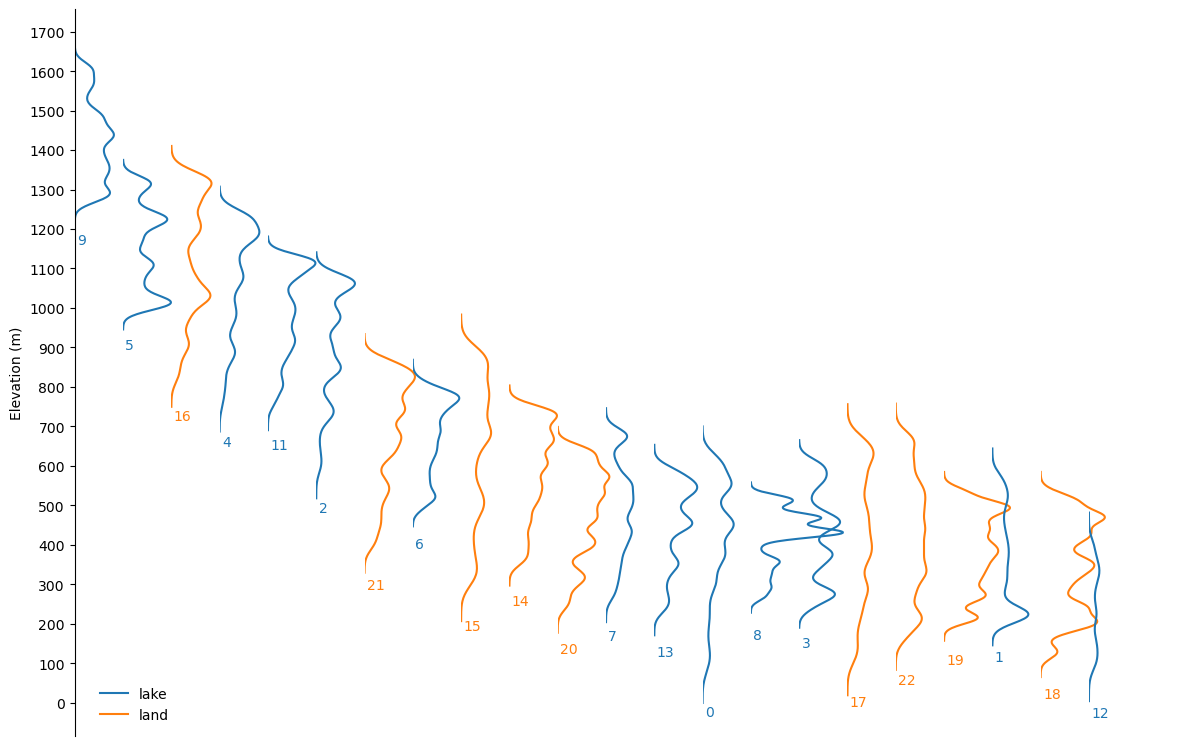

In [9]:
## hypsometry
col_order = samples.loc[(samples['where']=='greenland')].groupby(['lake_land', 'id'])['z_median'].median().reset_index().sort_values(by=['z_median', 'lake_land'], ascending=False)['id'].tolist()
cdict = {'lake': 'tab:blue',
         'land': 'tab:orange'}

fg = sns.displot(data=samples.loc[(samples['where']=='greenland')],
            y='z_median',
            col='id',
            col_order=col_order,
            hue='lake_land',
            kind='kde',
            # common_norm=True,
            aspect=1/15, 
            height=8      
            )

fg.figure.subplots_adjust(wspace=-0.5)

# Remove axes details that don't play well with overlap
fg.set_titles("")
fg.set(xticks=[], xlabel="")
fg.despine(bottom=True, left=True, right=True, top=True)

for i, ax in enumerate(fg.axes.flat):
    ax.set_yticks(np.arange(0,1800,100))
    ax.set_facecolor('none')
    if i == 0:
        # ax.set_yticks([])
        # ax.set_yticks(np.arange(0,1600,100))
        ax.spines['left'].set_visible(True)
        ax.set_ylabel('Elevation (m)')
    else:
        ax.tick_params(axis='both', which='both', length=0)

for ax, id in zip(fg.axes[0], col_order):
    ll = centrelines.loc[id, 'lake_land']
    min_z = samples.loc[samples['id']==id, 'z_median'].min()
    ax.annotate(id,
                xy=(0.00001, min_z-100),
                xycoords='data',
                color=cdict[ll])
    
fg.legend.set_title(None)
sns.move_legend(fg, loc='lower left', bbox_to_anchor=(0.05, 0.05))

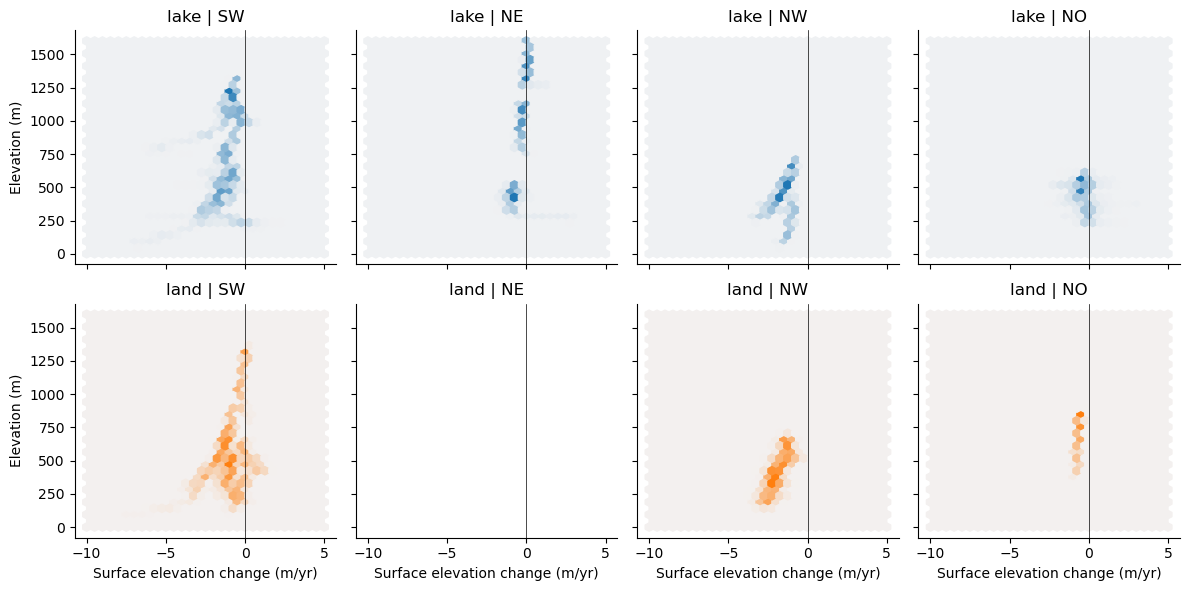

In [11]:
# SEC against elevation by lake/land and greenland basin
fg = sns.FacetGrid(samples.loc[samples['where']=='greenland'],
                    col='region',
                    row='lake_land',
                    hue='lake_land',
                    hue_order=['lake', 'land'],
                    row_order=['lake', 'land'],
                    col_order=centrelines['region'].value_counts().index.tolist()
)
fg.map(hexbin, "slope", "z_median", extent=[-10,5,0,1600])

for ax in fg.axes.flat:
    t = ax.get_title()
    t = t.replace('region = ', "").replace('lake_land = ', "")
    ax.set_title(t)
    ax.axvline(0, c='k', lw=0.5)

fg.set(xlabel='Surface elevation change (m/yr)',
       ylabel='Elevation (m)')

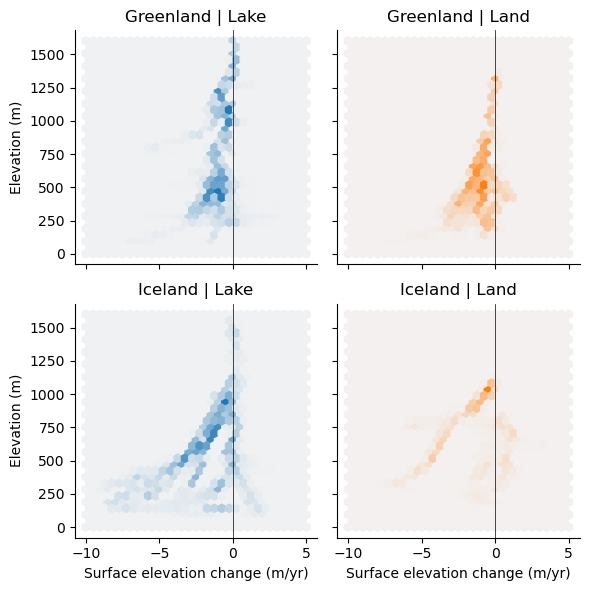

In [12]:
# SEC against elevation by lake/land and greenland/iceland

fg = sns.FacetGrid(samples,
                    row='where',
                    col='lake_land',
                    hue='lake_land',
                    hue_order=['lake', 'land'],
                    row_order=['greenland', 'iceland'],
                    col_order=['lake', 'land'],
)
fg.map(hexbin, "slope", "z_median", extent=[-10,5,0,1600])

for ax in fg.axes.flat:
    t = ax.get_title()
    t = t.replace('where = ', "").replace('lake_land = ', "")
    ax.set_title(t.title())
    ax.axvline(0, c='k', lw=0.5)

fg.set(xlabel='Surface elevation change (m/yr)',
       ylabel='Elevation (m)')

- bin elevations into 20 m (or 50 or whatever) wide buckets
- group all the samples by:
    - mid value of this bucket
    - iceland / greenland
    - greenland region
    - lake / land
- for each group compute the median, lower quartile and upper quartile of the rates of SEC

for compatability with `plt.errorbar()` need to add/subtract the upper/lower quartiles from the median

In [13]:
# bin elevations
bin_width = 25
samples['z_bins'] = pd.cut(samples['z_median'], np.arange(12.5, 1812.5, bin_width))
samples['mid_bin'] = samples['z_bins'].apply(lambda x: int(x.mid)).astype(int)

Text(0, 0.5, 'Elevation (m)')

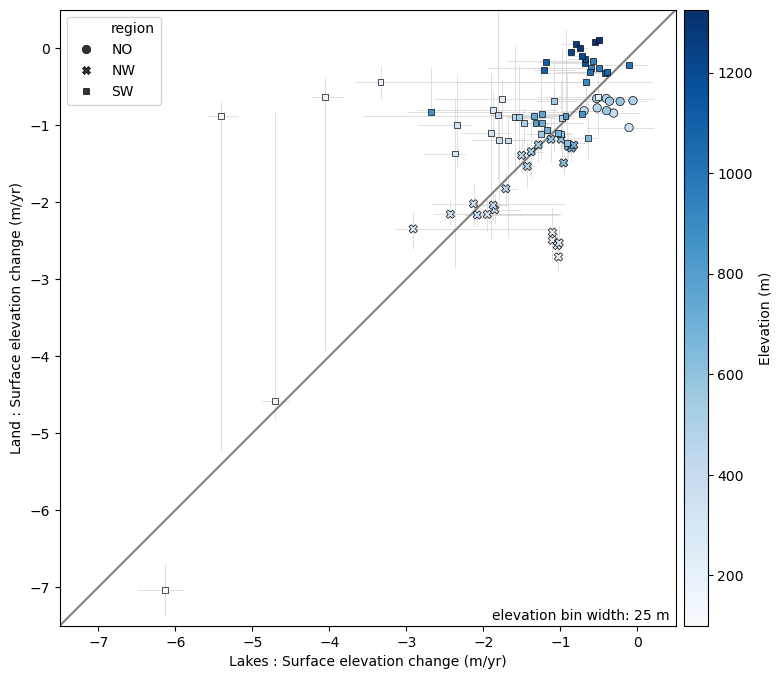

In [14]:
# scatter of lake vs land SEC for GREENLAND ONLY, coloured by elevation, symbolised by region
lake_land_df = samples_groupby(samples, ['where', 'region', 'lake_land', 'mid_bin'])

# plotting
fig, ax = plt.subplots(figsize=[8,8])
sns.scatterplot(data=lake_land_df.loc[lake_land_df['where']=='greenland'],
                x='lake_median',
                y='land_median',
                style='region',
              #   markers=['o','s'],
                hue='mid_bin',
                palette='Blues',
                ec='k',
                ax=ax,
                legend="full",
                )

# quick sort of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-4:], labels[-4:])

ax.errorbar(x='lake_median',
            y='land_median',
            yerr=np.c_[lake_land_df['land_low_err'].values,
                       lake_land_df['land_up_err'].values].T,
            xerr=np.c_[lake_land_df['lake_low_err'].values,
                       lake_land_df['lake_up_err'].values].T,
            data=lake_land_df,
            fmt='none',
            ecolor='lightgray',
            elinewidth=0.5,
            zorder=0)

# limits and aspect ratio and x=y line
ax.set(
  xlim=(-7.5, 0.5),
  ylim=(-7.5, 0.5),
  xlabel='Lakes : Surface elevation change (m/yr)',
  ylabel='Land : Surface elevation change (m/yr)')
ax.set_aspect('equal')

ax.annotate(f'elevation bin width: {bin_width} m',
            xy=(0.99, 0.01),
            ha='right',
            xycoords='axes fraction')

plot_xeqy(ax)


########## elevation colorbar
norm = plt.Normalize(*lake_land_df['mid_bin'].agg(['min', 'max']))
cmap = plt.get_cmap('Blues')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.01,
                    pos.y0,
                    0.03,
                    pos.height])

cb = plt.colorbar(sm, cax=cax)
cax.set_ylabel('Elevation (m)')

Text(0.5, 0, '<--- more thinning at lake <---| lake SEC - land SEC |---> more thinning at land --->')

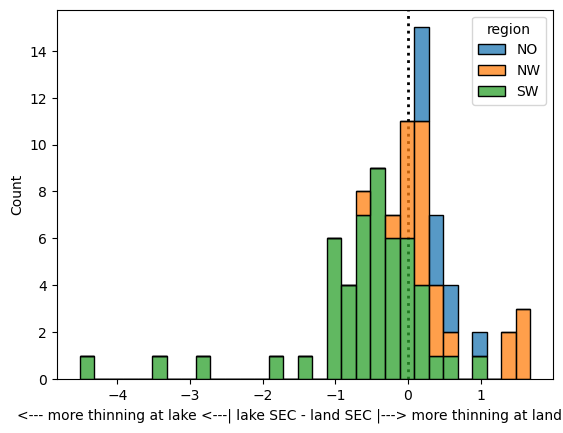

In [15]:
lake_land_df['diff_lake_sub_land'] = lake_land_df['lake_median'] - lake_land_df['land_median']

ax = sns.histplot(data=lake_land_df,
                 x='diff_lake_sub_land',
                 hue='region',
                #  palette=['tab:green', 'tab:pink'],
                 binwidth=0.2,
                 multiple='stack'
                 )

ax.axvline(0, c='k', zorder=0, lw=2, ls=':')

ax.set_xlabel('<--- more thinning at lake <---| lake SEC - land SEC |---> more thinning at land --->')

{450, 425, 525, 400, 500, 375, 475}


Text(1.17, 0.7, 'only showing SEC distributions\n for elevation bins:\n{450, 425, 525, 400, 500, 375, 475}\nas all regions have samples\nfrom within these ranges\nfor both lake and land')

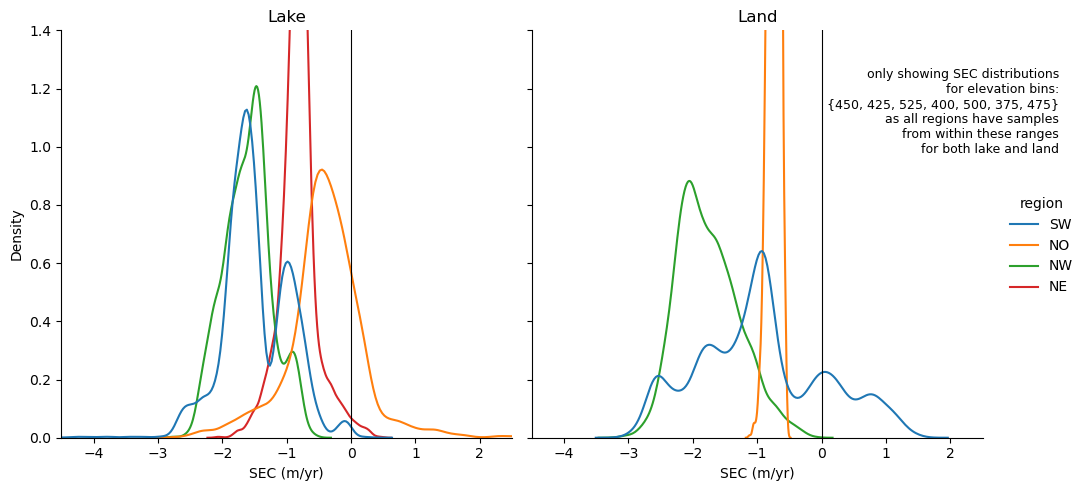

In [70]:
sets = samples.groupby(['region', 'lake_land'])['mid_bin'].apply(lambda x: set(x))
common_zs = set.intersection(*sets.tolist())
# fig, ax = plt.subplots()
print(common_zs)
fg = sns.displot(
       samples.loc[(samples['where']=='greenland') & (samples['mid_bin'].isin(common_zs))],
                 x='slope',
                 hue='region',
                 common_norm=False,
                 kind='kde',
                 col='lake_land',
                 col_order=['lake', 'land'])

fg.set(ylim=(0, 1.4),
       xlim=(-4.5, 2.5),
       xlabel=('SEC (m/yr)'))

for ax in fg.axes.flat:
    ax.axvline(0, c='k', lw=0.8)
    ax.set_title(ax.get_title().split('= ')[-1].title())
    
ax.annotate(f'only showing SEC distributions\n for elevation bins:\n{common_zs}\nas all regions have samples\nfrom within these ranges\nfor both lake and land',
            xy=(1.17, 0.7),
            xycoords='axes fraction',
            fontsize=9,
            ha='right')

Text(0, 0.5, 'Elevation (m)')

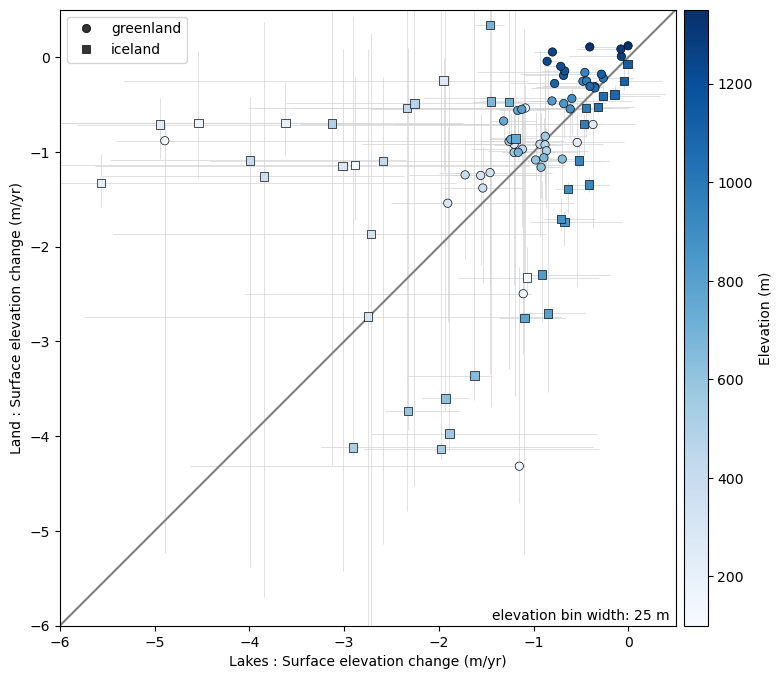

In [71]:
# scatter of lake vs land SEC for coloured by elevation, symbolised by greenland/iceland

lake_land_df = samples_groupby(samples, ['where', 'lake_land', 'mid_bin'])

fig, ax = plt.subplots(figsize=[8,8])
sns.scatterplot(data=lake_land_df,
                x='lake_median',
                y='land_median',
                style='where',
                markers=['o','s'],
                hue='mid_bin',
                palette='Blues',
                ec='k',
                ax=ax,
                legend='brief'
                )

# quick sort of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:])

ax.errorbar(x='lake_median',
            y='land_median',
            yerr=np.c_[lake_land_df['land_low_err'].values,
                       lake_land_df['land_up_err'].values].T,
            xerr=np.c_[lake_land_df['lake_low_err'].values,
                       lake_land_df['lake_up_err'].values].T,
            data=lake_land_df,
            fmt='none',
            ecolor='lightgray',
            elinewidth=0.5,
            zorder=0)

# limits and aspect ratio and x=y line
ax.set(xlim=(-6, 0.5),
       ylim=(-6, 0.5),
       xlabel='Lakes : Surface elevation change (m/yr)',
       ylabel='Land : Surface elevation change (m/yr)')
ax.set_aspect('equal')
plot_xeqy(ax)

ax.annotate(f'elevation bin width: {bin_width} m',
            xy=(0.99, 0.01),
            ha='right',
            xycoords='axes fraction')

########## elevation colorbar
norm = plt.Normalize(*lake_land_df['mid_bin'].agg(['min', 'max']))
cmap = plt.get_cmap('Blues')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.01,
                    pos.y0,
                    0.03,
                    pos.height])

cb = plt.colorbar(sm, cax=cax)
cax.set_ylabel('Elevation (m)')

## velocity

In [77]:
s12, s7 = utils.Site(12), utils.Site(7)

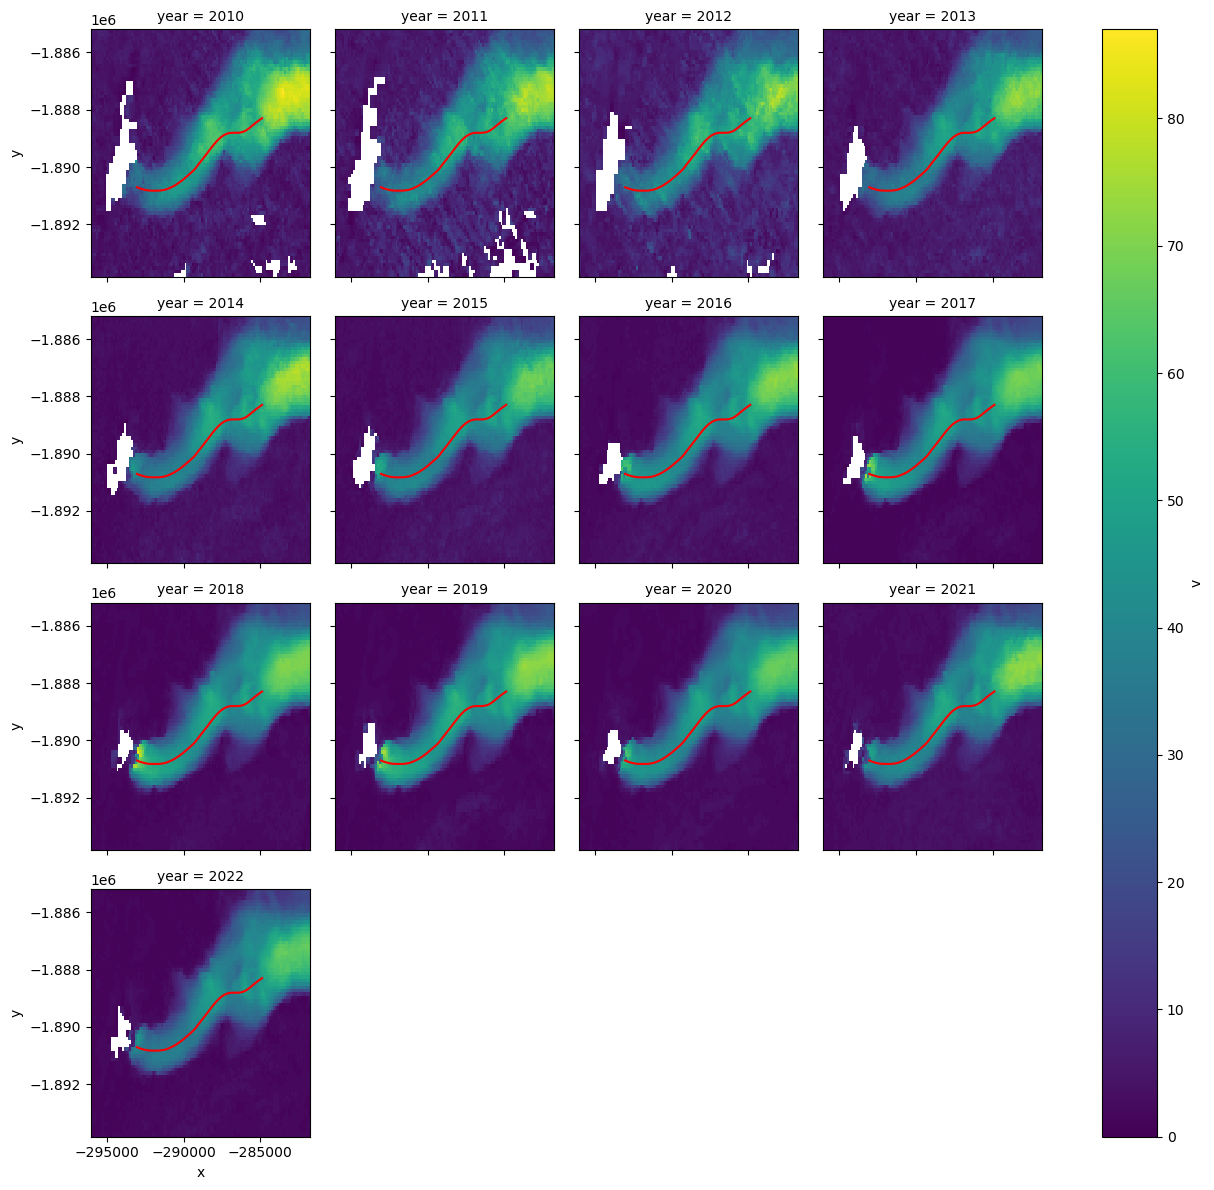

In [84]:
fg = s7.v_field['v'].sel(quantile=0.5).plot(col='year', col_wrap=4)

for ax in fg.axs.flat:
    ax.plot(*s7.cl.coords.xy, c='r')

### results

In [174]:
v_cl_files = glob('../results/velocity/centreline_trend/*')

def id_from_path(path):
    return int(os.path.basename(path).split('_')[0].split('id')[-1])

cl_trend_dfs = []
for f in v_cl_files:
    id = id_from_path(f)
    if id in [10, 32]:
        continue
    else:
        _df = pd.read_parquet(f)
        _df['id'] = id
        _df['where'] = centrelines.loc[id,'where']
        _df['lake_land'] = centrelines.loc[id, 'lake_land']
        cl_trend_dfs.append(_df)
    
cl_trend = pd.concat(cl_trend_dfs).reset_index()

# cl_trend = cl_trend[cl_trend['cumul_dist'] % 0.25 == 0]
# cl_trend = cl_trend[cl_trend['slope'].abs() < 30]

In [ ]:
fg = sns.relplot(data=cl_trend,
                 x='cumul_dist',
                 y='slope',
                 hue='lake_land',
                 hue_order=['lake', 'land'],
                 col='where',
                 kind='line',
                 errorbar='sd',
                 marker='.'
                 )

fg.set(ylim=(-10,10),
       xlabel='Distance from terminus (km)',
       ylabel='Velocity trend (m yr^-2)')
fg.map(plt.axhline, y=0, c='k', lw=1, zorder=0)

for ax in fg.axes.flat:
       t = ax.get_title()
       ax.set_title(t.split('where = ')[-1].title())
       
fg.axes[0][0].annotate(
       'line = mean\nshading = st dev',
       xy=(0.99, 0.03),
       xycoords='axes fraction',
       ha='right'
)

In [ ]:
lower = lambda x: np.quantile(x, 0.25)
upper = lambda x: np.quantile(x, 0.75)
avg_cl_trends = (cl_trend
                 .groupby(['where', 'lake_land', 'cumul_dist'])['slope']
                 .agg(['median', lower, upper])
                 .rename(columns={'<lambda_0>':'lower',
                                  '<lambda_1>':'upper'})
                 .reset_index()
                 )
avg_cl_trends.head(2)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=[8,4], sharex=True, sharey=True)
for ax, where in zip(axs, ['greenland', 'iceland']):
    for ll in ['lake', 'land']:
        idx = (avg_cl_trends['where'] == where) & (avg_cl_trends['lake_land'] == ll)

        ax.fill_between(avg_cl_trends.loc[idx, 'cumul_dist'],
                        y1=avg_cl_trends.loc[idx, 'lower'],
                        y2=avg_cl_trends.loc[idx, 'upper'],
                        alpha=0.5, label=ll)
        
        ax.plot(avg_cl_trends.loc[idx, 'cumul_dist'],
                avg_cl_trends.loc[idx, 'median'])
    
    ax.axhline(0, c='k', lw=1, zorder=0)

    ax.set_xlim(0,10)
    ax.set_ylim(-2,2)
    ax.set_xlabel('Distance from terminus (km)')
    ax.set_title(where.title())
    if where=='greenland':
        ax.set_ylabel('Velocity trend (m yr^-2)')
        ax.legend(frameon=False)

# now = pd.Timestamp.now().strftime('%y%m%d_%H%M') + '_'
# directory = '../results/figures/'
# filename = 'median_centreline_velocity_trends_iqr.png'
# fig.savefig(directory + now + filename, bbox_inches = 'tight')

In [ ]:
line_df_split = samples_groupby(cl_trend, by=['where', 'lake_land', 'cumul_dist'])
# scatter of lake vs land V for GREENLAND ONLY, coloured by elevation, symbolised by region

# plotting
fig, ax = plt.subplots(figsize=[8,8])
sns.scatterplot(data=line_df_split.loc[line_df_split['where']=='greenland'],
                x='lake_median',
                y='land_median',
                # style='region',
              #   markers=['o','s'],
                hue='cumul_dist',
                palette='Blues',
                ec='k',
                ax=ax,
                legend=False,
                )

# quick sort of legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[-2:], labels[-2:])

ax.errorbar(x='lake_median',
            y='land_median',
            yerr=np.c_[line_df_split['land_low_err'].values,
                       line_df_split['land_up_err'].values].T,
            xerr=np.c_[line_df_split['lake_low_err'].values,
                       line_df_split['lake_up_err'].values].T,
            data=line_df_split,
            fmt='none',
            ecolor='lightgray',
            elinewidth=0.5,
            zorder=0)

# limits and aspect ratio and x=y line
ax.set(
  xlim=(-2, 1.5),
  ylim=(-2, 1.5),
  xlabel='Lakes : Velocity trend (m yr^-2)',
  ylabel='Land : Velocity trend (m yr^-2)')
ax.set_aspect('equal')

# ax.annotate(f'elevation bin width: {bin_width} m',
#             xy=(0.99, 0.01),
#             ha='right',
#             xycoords='axes fraction')

plot_xeqy(ax)
ax.axhline(0, c='k', lw=0.5)
ax.axvline(0, c='k', lw=0.5)


########## elevation colorbar
norm = plt.Normalize(*line_df_split['cumul_dist'].agg(['min', 'max']))
cmap = plt.get_cmap('Blues')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.01,
                    pos.y0,
                    0.03,
                    pos.height])

cb = plt.colorbar(sm, cax=cax)
cax.set_ylabel('Distance from terminus (km)')


ax.annotate('<-- decelerating   accelerating -->',
            xy=(0, -1.75),
            xycoords='data',
            ha='center')

ax.annotate('<-- decelerating   accelerating -->',
            xy=(-1.75, 0),
            xycoords='data',
            ha='center',
            va='center',
            rotation=90)



# now = pd.Timestamp.now().strftime('%y%m%d_%H%M') + '_'
# directory = '../results/figures/'
# filename = 'median_centreline_velocity_trends_iqr.png'
# fig.savefig(directory + now + filename, bbox_inches = 'tight')

### fixing centreliner

In [ ]:
from velocity_utils import CentreLiner
with LocalCluster() as cluster:
    client = cluster.get_client()
    print(client.dashboard_link)
    
    params = {'ddt_range': [pd.Timedelta(td) for td in ('335d', '395d')],
            'middate_range': (pd.to_datetime('2010-01-01'), pd.Timestamp.now())}


    V = CentreLiner(geo=centrelines.loc[6, 'geometry'],
                    buff_dist=3000,
                    index=6,
                    sample_centreline=True,
                    filter=True,
                    get_robust_trend=False,
                    get_annual_quantiles=False,
                    get_rgb=False,
                    **params)


In [10]:
import utils
from scipy.stats import theilslopes
from sklearn.linear_model import LinearRegression, TheilSenRegressor
import utils

In [5]:
s6 = utils.Site(6)
grps = V.filtered_line_df.groupby('cumul_dist')
ts_results = []
cumul_dist = []
for name, group in grps:
    ts_results.append(tsr(group)[0])
    cumul_dist.append(name)
_df = pd.DataFrame({'sk_slope':ts_results}, index=cumul_dist)
_df['scipy_slope'] = s6.v_cl['slope']
_df.plot.scatter(x='sk_slope', y='scipy_slope')

In [46]:
from scipy.stats import distributions
from scipy.stats._stats_mstats_common import _find_repeats

In [28]:
def tsr(df, alpha=0.95):
    x = ((df['mid_date'] - df['mid_date'].min()) / pd.Timedelta('365.25d')).values
    y = df['v'].values
    
    tsr = TheilSenRegressor(random_state=45,
                             verbose=False,
                             n_jobs=-1).fit(x.reshape(-1, 1), y)
    
    z = distributions.norm.ppf(alpha / 2)
    _, nxreps = _find_repeats(x)
    _, nyreps = _find_repeats(y)
    nt = 1       # N in Sen (1968)
    ny = len(y)            # n in Sen (1968)
    sigsq = 1/18. * (ny * (ny-1) * (2*ny+5) -
                    sum(k * (k-1) * (2*k + 5) for k in nxreps) -
                    sum(k * (k-1) * (2*k + 5) for k in nyreps))
    
    try:
        sigma = np.sqrt(sigsq)
        Ru = min(int(np.round((nt - z*sigma)/2.)), len(slopes)-1)
        Rl = max(int(np.round((nt + z*sigma)/2.)) - 1, 0)
        delta = slopes[[Rl, Ru]]
    except (ValueError, IndexError):
        delta = (np.nan, np.nan)
    
    return 
    
    

In [ ]:
from scipy import stats

def get_conf_int(alpha, lr, X, y):
    
    """
    Returns (1-alpha) 2-sided confidence intervals
    for sklearn.LinearRegression coefficients
    as a pandas DataFrame
    """
    
    coefs = np.r_[[lr.intercept_], lr.coef_]
    X_aux = X.copy()
    X_aux.insert(0, 'const', 1)
    dof = -np.diff(X_aux.shape)[0]
    mse = np.sum((y - lr.predict(X)) ** 2) / dof
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    t_val = stats.t.isf(alpha/2, dof)
    gap = t_val * np.sqrt(mse * var_params)

    return pd.DataFrame({
        'lower': coefs - gap, 'upper': coefs + gap
    }, index=X_aux.columns)

In [ ]:
X = pd.DataFrame(((group['mid_date'] - group['mid_date'].min()) / pd.Timedelta('365.25d')).reset_index(drop=True))
y = group['v']

lr = TheilSenRegressor(random_state=45,
                       verbose=False,
                       ).fit(X, y)
alpha = 0.05
get_conf_int(alpha, lr, X, y)

In [ ]:
(50_000 ** 2) /2

In [ ]:
s6.v_field['v'].sel(quantile=0.5).polyfit(dim='year', deg=1)['polyfit_coefficients'][0].plot(robust=True)

In [ ]:
s6.v_field['v'].sel(quantile=0.5).plot(col='year', col_wrap=4)

In [ ]:
V.filtered_line_df.loc[V.filtered_line_df['cumul_dist']==5.75].plot.scatter(y='v', x='mid_date', marker='.')

In [ ]:
s6.v_cl

In [ ]:
X

In [ ]:
coefs = np.r_[[lr.intercept_], lr.coef_]
X_aux = X.copy()
X_aux.insert(0, 'const', 1)
# X_aux = np.c_[np.ones(len(X)), X]
dof = -np.diff(X_aux.shape)[0]
mse = np.sum((y - lr.predict(X)) ** 2) / dof
var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
t_val = stats.t.isf(alpha/2, dof)
gap = t_val * np.sqrt(mse * var_params)

In [ ]:
conf, X_aux = get_conf_int(0.05, lr, X, y)